In [1]:
import os
import numpy 
from scipy import integrate, linalg 
from matplotlib import pyplot

# integrate plots into the notebook 
%matplotlib inline

In [2]:
Main_x,Main_y= numpy.loadtxt("../AeroPython/lessons/resources/MainFoil_N=200.csv", dtype=float, delimiter=',', unpack=True)
Foil_x,Foil_y = numpy.loadtxt("../AeroPython/lessons/resources/FlapFoil_N=200.csv", dtype=float, delimiter=',', unpack=True)

In [3]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [4]:
def define_panels(x, y, N):
    """
    Discretizes the geometry into panels using 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects.
        The list of panels.
    """
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    return panels

In [5]:
N=numpy.size(Main_x)-1
panels_main = define_panels(Main_x,Main_y, N)
panels_flap = define_panels(Foil_x,Foil_y, N)
u_inf, alpha = 1.0, 0.0

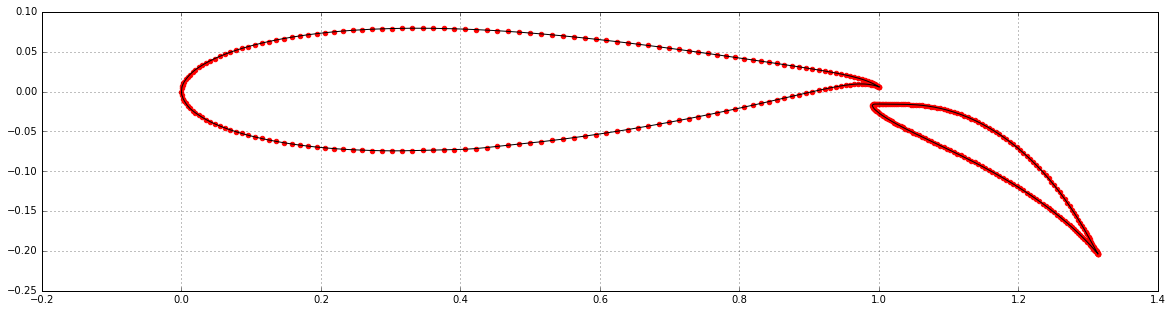

In [6]:
pyplot.figure(figsize=(20,5))
pyplot.plot(Main_x,Main_y, Foil_x,Foil_y,  color='k', linestyle='-', linewidth=1);
pyplot.grid(True)
panel_main, panel_flap = define_panels(Main_x,Main_y, N), define_panels(Foil_x,Foil_y, N)
pyplot.scatter([panel.xa for panel in panel_main], [panel.ya for panel in panel_main], color='red');
pyplot.scatter([panel.xa for panel in panel_flap], [panel.ya for panel in panel_flap], color='red');

In [7]:
class Freestream: 
    """
    Freestream conditions. 
    """
    def __init__(self, u_inf =1.0, alpha =0.0):
     
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0

freestream = Freestream(u_inf=1.0, alpha = 0.0)

In [8]:
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [9]:
def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, panel_j,numpy.cos(panel_i.beta),numpy.sin(panel_i.beta))
    return A

In [10]:
def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A


In [11]:
panels=numpy.empty(N*2, dtype=object)
for i in range(N*2):
    if i<N:
        panels[i]=panels_main[i]
    elif i>=N:
        panels[i]=panels_flap[i-N]

A_source=source_contribution_normal(panels)
B_vortex= vortex_contribution_normal(panels)

In [12]:
def kutta_condition(A_source, B_vortex):
    b = numpy.empty([2,A_source.shape[1]+2],dtype=float)
    b[0,:-2] = B_vortex[0, :] + B_vortex[N-1, :]
    b[1,:-2] = B_vortex[N, :] + B_vortex[2*N-1, :]
    
    b[-2,-2]=- numpy.sum(A_source[0,:N] + A_source[N-1,:N])
    b[-2,-1]=- numpy.sum(A_source[0,N:] + A_source[N-1,N:])
    b[-1,-2]=- numpy.sum(A_source[N,:N] + A_source[2*N-1,:N])
    b[-1,-1]=- numpy.sum(A_source[N,N:] + A_source[2*N-1,N:])
    
    return b

In [13]:
def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0]+2, A_source.shape[0]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = numpy.sum(B_vortex[:,:N], axis=1)    
    A[:-2, -1] = numpy.sum(B_vortex[:,N:], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    return A

In [14]:
def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[N-1].beta) )
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[N].beta)
                               +numpy.sin(freestream.alpha-panels[2*N-1].beta) )
    return b

In [16]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)


In [17]:
def compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size+2), dtype=float)
    A[:, :-2] = B_vortex
    A[:, -2] = -numpy.sum(A_source[:,:N], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,N:], axis=1)
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    strengths = numpy.append([panel.sigma for panel in panels],gamma_m)
    strengths = numpy.append(strengths,gamma_f)
    tangential_velocities = numpy.dot(A, strengths) + b
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [18]:
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [19]:
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma_m = strengths[-2]
gamma_f = strengths[-1]

compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)

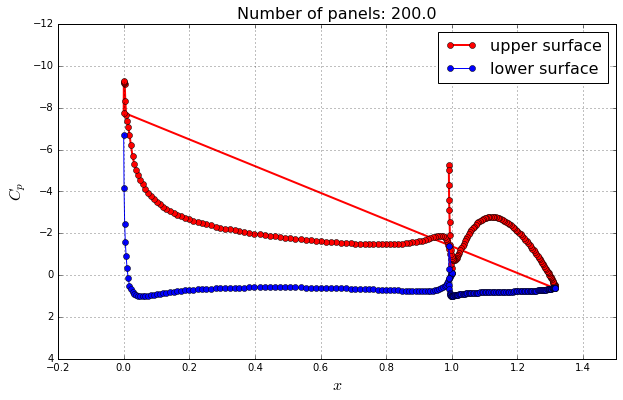

In [20]:
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.2, 1.5)
pyplot.ylim(-12, 4.0)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels: {}'.format(panels.size*0.5), fontsize=16);

In [22]:
print(panels[2].cp)

-0.553530359708


In [23]:
print(panels[N+9].cp)

0.262580530047


In [24]:
lift, drag = 0, 0

for panel in panels:
    lift -= panel.cp*numpy.sin(panel.beta)*panel.length
    drag += panel.cp*numpy.cos(panel.beta)*panel.length